### Import necessary Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Initialise some variables

In [24]:
IMAGE_SIZE_1 = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

### Importing the dataset

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/My Drive/data_images",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=True,
        )

Found 9835 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy']

In [10]:
import tensorflow as tf

BATCH_SIZE = 32
IMAGE_SIZE = 128

dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/data_images",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

class_counts = {}
for images, labels in dataset:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} images")


Found 9835 files belonging to 5 classes.
Class 4: 1591 images
Class 3: 3208 images
Class 0: 2127 images
Class 1: 1000 images
Class 2: 1909 images


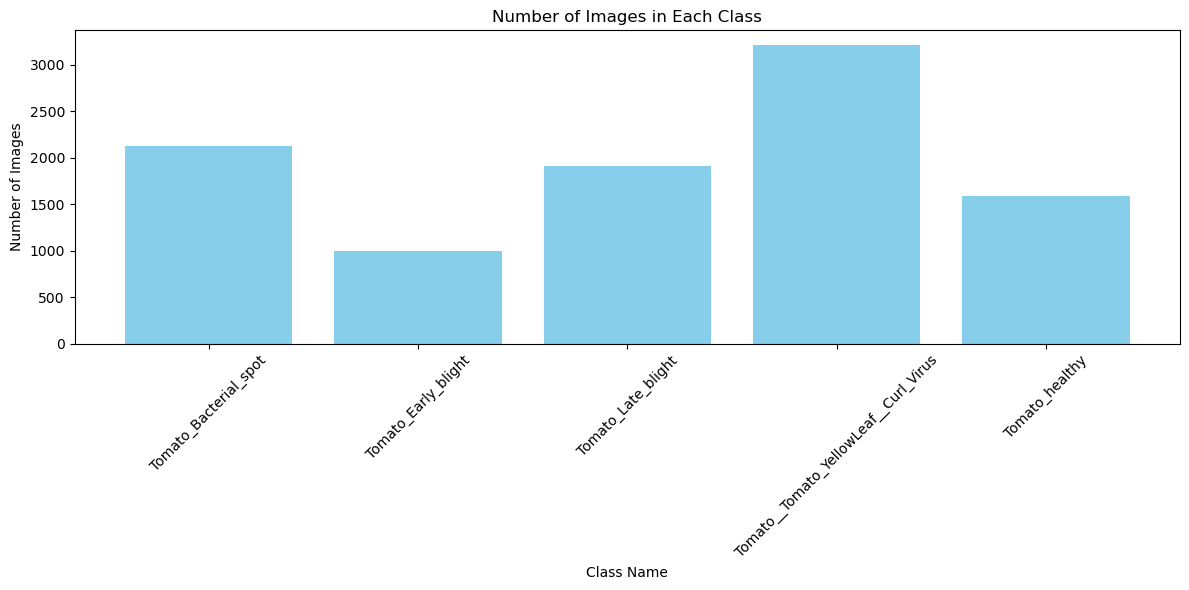

In [ ]:
class_names = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
len(dataset)   #32 images per batch means 308 batches

308

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 3 0 1 2 3 0 0 0 0 4 1 3 0 2 0 2 4 4 3 3 0 0 3 2 3 3 3 4 2 4 4]


In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[146.5  132.5  129.5 ]
  [159.75 145.75 142.75]
  [160.25 146.25 143.25]
  ...
  [137.75 119.75 117.75]
  [138.5  120.5  118.5 ]
  [127.   109.   107.  ]]

 [[148.   134.   131.  ]
  [142.75 128.75 125.75]
  [145.5  131.5  128.5 ]
  ...
  [126.   108.   106.  ]
  [147.   129.   127.  ]
  [122.25 104.25 102.25]]

 [[151.25 137.25 134.25]
  [154.   140.   137.  ]
  [155.5  141.5  138.5 ]
  ...
  [141.75 123.75 121.75]
  [135.   117.   115.  ]
  [135.75 117.75 115.75]]

 ...

 [[124.   106.   104.  ]
  [120.25 102.25 100.25]
  [123.25 105.25 103.25]
  ...
  [101.5   83.5   79.5 ]
  [105.25  87.25  83.25]
  [108.    90.    86.  ]]

 [[126.25 108.25 106.25]
  [124.5  106.5  104.5 ]
  [118.25 100.25  98.25]
  ...
  [112.    94.    90.  ]
  [116.25  98.25  94.25]
  [114.    96.    92.  ]]

 [[124.75 106.75 104.75]
  [125.5  107.5  105.5 ]
  [121.5  103.5  101.5 ]
  ...
  [116.5   98.5   94.5 ]
  [106.5   88.5   84.5 ]
  [103.5   85.5   81.5 ]]]


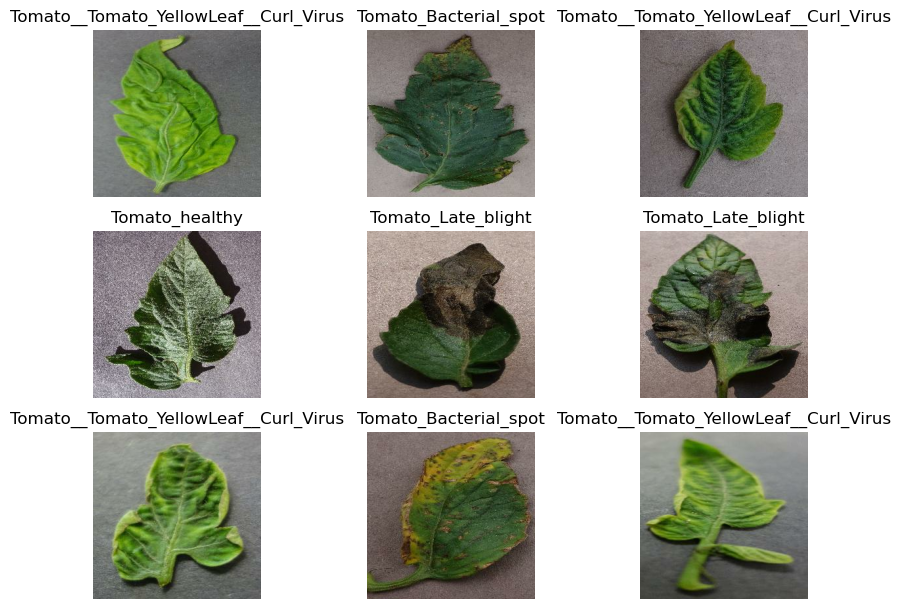

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Train Test Split

- 80% of the data will be for training;
- 10% for validation;
- 10% test.

In [12]:
data_size = len(dataset)

In [13]:
test_size = 0.8*data_size
test_size

246.4

In [ ]:
test_set = dataset.take(246)

In [ ]:
val_test_size = dataset.skip(246)
len(val_test_size)

62

In [ ]:
val_set = val_test_size.take(31)
len(val_set)

31

In [ ]:
test_set = val_test_size.skip(31)
len(test_set)

31

### Creating a function for the split

In [14]:
def get_dataset_splits(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds.shuffle(shuffle_size, seed=12)

    # Get split sizes
    train_size = int(ds_size * train_split)
    val_size = int(val_split * ds_size)

    #Get the training, validataion and test sets
    train_set = ds.take(train_size)
    val_set = ds.skip(train_size).take(val_size)
    test_set = ds.skip(train_size).skip(val_size)


    return train_set, val_set, test_set

In [15]:
train_ds, val_ds, test_ds = get_dataset_splits(dataset)

In [16]:
len(train_ds)

246

In [17]:
len(val_ds)

30

In [18]:
len(test_ds)

32

### Data Preprocessing Pipeline

In [19]:
train_ds  = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds    = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds   = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
                    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                    layers.experimental.preprocessing.Rescaling(1.0/255),

                    ])

In [21]:
image_augmentation = tf.keras.Sequential([
                    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                    layers.experimental.preprocessing.RandomRotation(0.2),

                    ])

### Model Training

- 32 filters, each filter is a 3 by 3 pixels
- activation function is relU to introduce non-linearity
- MaxPooling was done with a 2 by 2 pixel. Preserves important features while removing unnecessary ones.

In [25]:
input_shape=(BATCH_SIZE, IMAGE_SIZE_1, IMAGE_SIZE_1, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    image_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 63, 63, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 30, 30, 64)          0         
 g2D)                                                 

In [27]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [28]:
history = model.fit(
        train_ds,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        verbose = 1,
        validation_data = val_ds
    )

Epoch 1/100
246/246 [==============================] - 62s 130ms/step - loss: 0.8056 - accuracy: 0.6968 - val_loss: 0.4687 - val_accuracy: 0.8396
Epoch 2/100
246/246 [==============================] - 5s 19ms/step - loss: 0.4081 - accuracy: 0.8520 - val_loss: 0.4248 - val_accuracy: 0.8521
Epoch 3/100
246/246 [==============================] - 5s 19ms/step - loss: 0.3205 - accuracy: 0.8834 - val_loss: 0.3682 - val_accuracy: 0.8740
Epoch 4/100
246/246 [==============================] - 5s 19ms/step - loss: 0.3038 - accuracy: 0.8871 - val_loss: 0.3782 - val_accuracy: 0.8740
Epoch 5/100
246/246 [==============================] - 4s 18ms/step - loss: 0.2432 - accuracy: 0.9106 - val_loss: 0.2545 - val_accuracy: 0.9208
Epoch 6/100
246/246 [==============================] - 5s 20ms/step - loss: 0.2158 - accuracy: 0.9234 - val_loss: 0.4975 - val_accuracy: 0.8313
Epoch 7/100
246/246 [==============================] - 5s 18ms/step - loss: 0.2046 - accuracy: 0.9243 - val_loss: 0.3119 - val_accurac

### Test the Model

On the training set, the model has an accuracy of **94.42%** with a loss of **0.1810**

In [29]:
scores = model.evaluate(test_ds)

32/32 [==============================] - 28s 18ms/step - loss: 0.0989 - accuracy: 0.9671


In [30]:
scores

[0.098879374563694, 0.9670987129211426]

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Evaluation of the model

- The accuracy may have increased if the number of epochs were increased
- the loss still had room to be reduced if the number of epochs were increased since it does not look like it had stabilised.

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Losses')

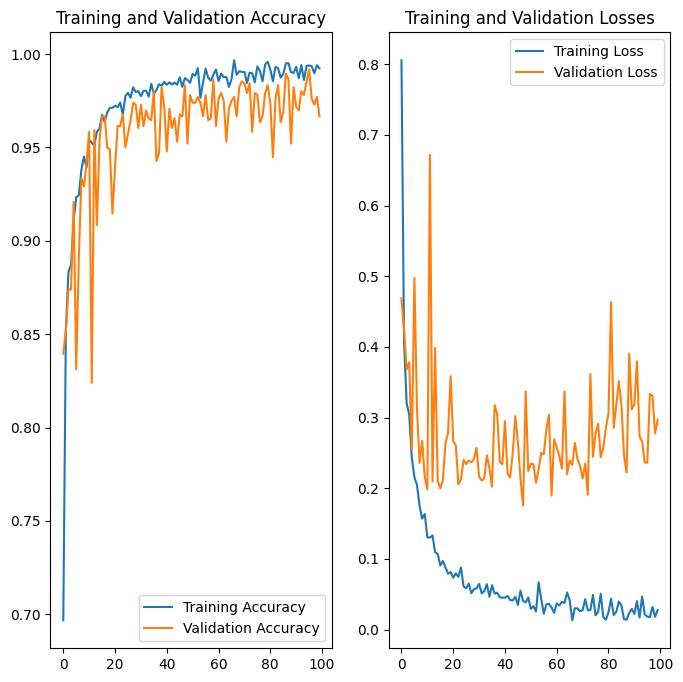

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Losses')

32/32 [==============================] - 0s 7ms/step
Confusion Matrix:
[[ 60  23  31  71  36]
 [ 18  13  22  32  15]
 [ 42  28  43  56  29]
 [ 78  33  52 118  48]
 [ 34  20  27  47  27]]

Precision Score: 0.2307674331463727
Recall Score: 0.230304218442052
Accuracy Score: 0.26021934197407776
F1 Score: 0.23017635272103557


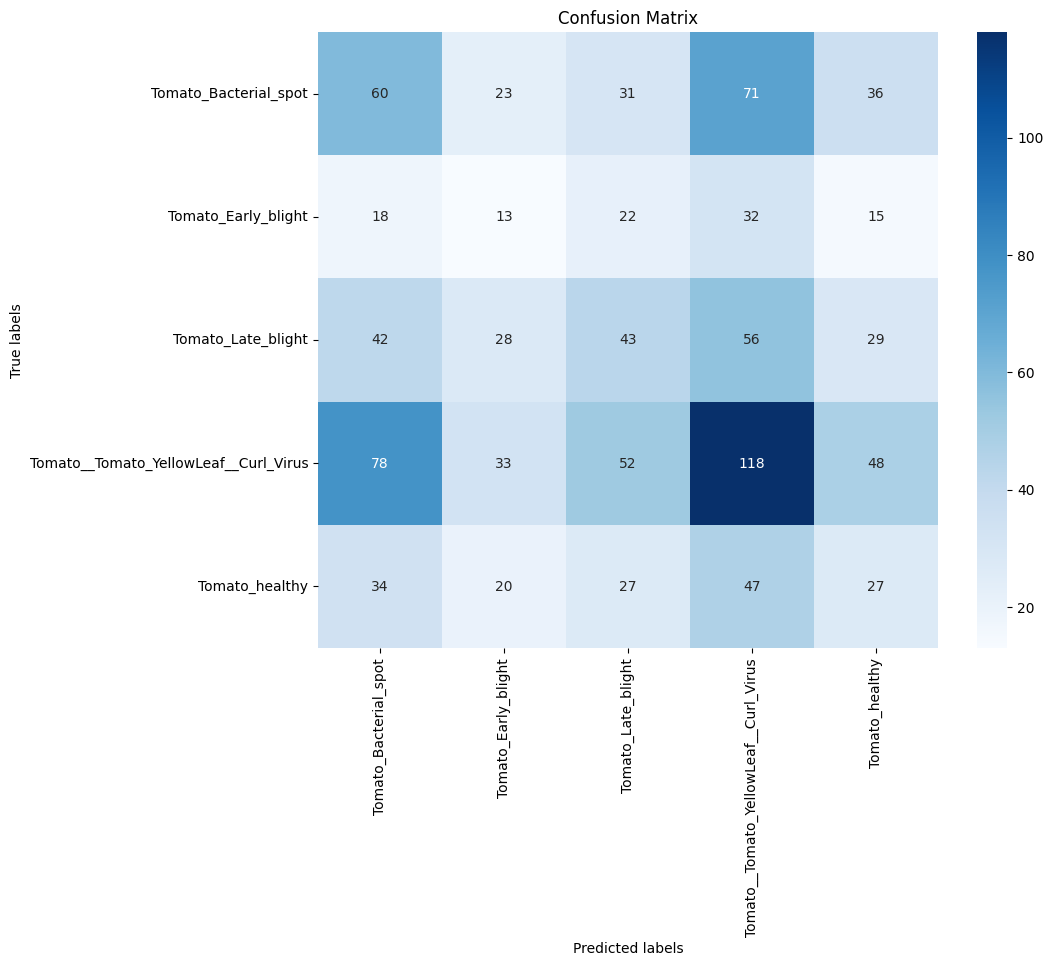

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Assuming model is already trained and test_ds is loaded
predictions = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate precision, recall, accuracy, and F1 score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print("Confusion Matrix:")
print(cm)
print("\nPrecision Score:", precision)
print("Recall Score:", recall)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Making predictions

In [35]:
for image_batch, label_batch in test_ds.take(1):
    print(image_batch[0].numpy())

[[[130.75 125.75 131.75]
  [126.25 121.25 127.25]
  [149.   144.   150.  ]
  ...
  [115.5  112.5  119.5 ]
  [115.   112.   119.  ]
  [141.25 138.25 145.25]]

 [[115.25 110.25 116.25]
  [141.25 136.25 142.25]
  [131.5  126.5  132.5 ]
  ...
  [129.75 126.75 133.75]
  [130.75 127.75 134.75]
  [117.75 114.75 121.75]]

 [[134.   129.   135.  ]
  [135.5  130.5  136.5 ]
  [142.   137.   143.  ]
  ...
  [120.75 117.75 124.75]
  [129.   126.   133.  ]
  [127.   124.   131.  ]]

 ...

 [[106.75 109.75 114.75]
  [ 80.    83.    88.  ]
  [ 89.5   92.5   97.5 ]
  ...
  [ 88.5   93.5   99.5 ]
  [ 73.5   78.5   84.5 ]
  [ 85.5   90.5   96.5 ]]

 [[113.75 116.75 121.75]
  [ 86.75  89.75  94.75]
  [ 93.75  96.75 101.75]
  ...
  [ 80.    85.    91.  ]
  [ 87.25  92.25  98.25]
  [ 79.    84.    90.  ]]

 [[ 99.25 102.25 107.25]
  [ 93.25  96.25 101.25]
  [ 75.    78.    83.  ]
  ...
  [ 91.25  96.25 102.25]
  [ 65.    70.    76.  ]
  [ 68.25  73.25  79.25]]]


In [36]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy']

first image to predict
actual label:  Tomato_Late_blight
1/1 [==============================] - 0s 272ms/step
Predicted label:  Tomato_Late_blight


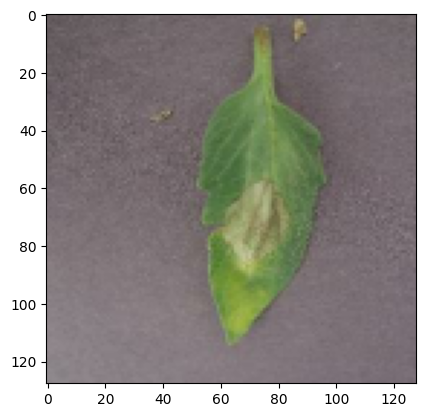

In [37]:
import numpy

for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])

    batch_predictions = model.predict(image_batch)
    print("Predicted label: ", class_names[numpy.argmax(batch_predictions[0])])  # numpy.argmax(batch_predictions[0] should give the index of max Val

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[numpy.argmax(predictions[0])]
    confidence = round(100 * (numpy.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


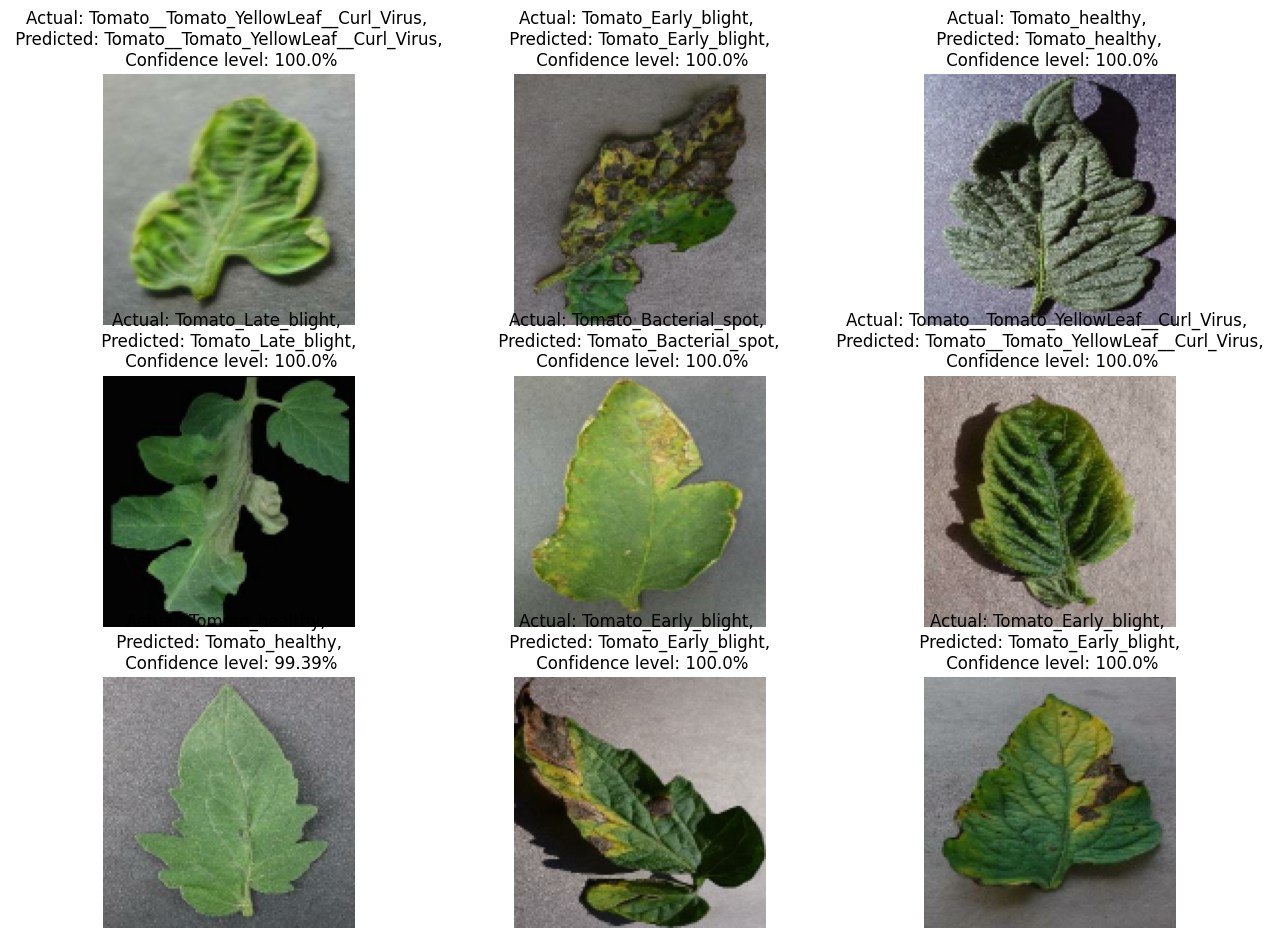

In [39]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence level: {confidence}%")
        plt.axis("off")

### Findings

- The confidence level for early bright seems to be lower. This might have to do the fact that it has the lowest dataset;
- The healthy leaves may not suffer the same issue despite still having a low data samples as well. This is probably because the
  images are uniquely different from all the other leaves

In [41]:
import os
model_dir = "/content/drive/My Drive/models"
model_version = max([int(i) for i in os.listdir(model_dir)] + [0]) + 1

# Save the model
model.save(f"{model_dir}/{model_version}")